In [1]:
#this chunk is necessary for importing correctly NeuralTree class in correct way
import os
import sys
sys.path.insert(0, os.path.abspath('./model'))

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import pickle as pkl

from sklearn.decomposition import PCA #features extraction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #data standardization
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.tree import plot_tree #visualize a decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.naive_bayes import GaussianNB, BernoulliNB #naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score #model evaluation metrics

from imblearn.over_sampling import SMOTE #package for using SMOTE for balance dataset

from model.NeuralTree import NeuralTree

%matplotlib inline

In [3]:
DATA_PATH_MALWARE = "../csv/malware"
DATA_PATH_GOODWARE = "../csv/goodware"
DATASET_PATH = "../csv"
EXPORTED_MODEL = "../exported_model"
col_names = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp',
             'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
             'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
             'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
             'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std',
             'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
             'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
             'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
             'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
             'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
             'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
             'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
             'Fwd Header Length_1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
             'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
             'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
             'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std',
             'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

# COSTRUZIONE DATASET
* avendo il dataset scomposto in molteplici *csv* vado a unirli in uno singolo, almeno per un primo momento, distinguendo i files contenti traffico benevolo e malevolo;
* rinomino i campi secondo le seguenti caratteristiche:
    * parole separate da spazio anzichè da '_';
    * prima lettera di ogni parola sarà maiuscola.
* a ogni record gli accosto un codice che identifica univocamnete il Sample che ha la seguete struttura: *{G,M}\_N*, dove:
    * **G** ed **M** indicano rispettivamente goodware e malware;
    * **N** indica il numero del sample preso in considerazione

In [38]:
def __change_name_and_order(data):
    new_names = list()
    #data = pd.read_csv(csv_path)

    for col in data.columns:
        new_name = col.split('_')
        new_names.append(" ".join(new_name).title()) #funzione title trasforma la prima lettera di ogni parola in maiuscolo (capitalizza)
        #print(new_name)
    data.columns = new_names

    #riordinamento delle features
    data = data.loc[:, ["Src Ip", "Src Port", "Dst Ip", "Dst Port", "Protocol", "Timestamp", "Flow Duration", "Tot Fwd Pkts",
           "Tot Bwd Pkts", "Totlen Fwd Pkts", "Totlen Bwd Pkts", "Fwd Pkt Len Max", "Fwd Pkt Len Min", "Fwd Pkt Len Mean",
           "Fwd Pkt Len Std", "Bwd Pkt Len Max", "Bwd Pkt Len Min", "Bwd Pkt Len Mean", "Bwd Pkt Len Std", "Flow Byts S",
           "Flow Pkts S", "Flow Iat Mean", "Flow Iat Std", "Flow Iat Max", "Flow Iat Min", "Fwd Iat Tot", "Fwd Iat Mean",
           "Fwd Iat Std", "Fwd Iat Max", "Fwd Iat Min", "Bwd Iat Tot", "Bwd Iat Mean", "Bwd Iat Std", "Bwd Iat Max",
           "Bwd Iat Min","Fwd Psh Flags", "Bwd Psh Flags", "Fwd Urg Flags", "Bwd Urg Flags",
           "Fwd Header Len", "Bwd Header Len", "Fwd Pkts S", "Bwd Pkts S", "Pkt Len Min", "Pkt Len Max", "Pkt Len Mean",
           "Pkt Len Std", "Pkt Len Var", "Fin Flag Cnt", "Syn Flag Cnt", "Rst Flag Cnt", "Psh Flag Cnt", "Ack Flag Cnt",
           "Urg Flag Cnt", "Cwe Flag Count", "Ece Flag Cnt", "Down Up Ratio", "Pkt Size Avg", "Fwd Seg Size Avg",
           "Bwd Seg Size Avg", "Fwd Header Len", "Fwd Byts B Avg", "Fwd Pkts B Avg", "Fwd Blk Rate Avg", "Bwd Byts B Avg",
           "Bwd Pkts B Avg", "Bwd Blk Rate Avg", "Subflow Fwd Pkts", "Subflow Fwd Byts", "Subflow Bwd Pkts",
           "Subflow Bwd Byts", "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Act Data Pkts", "Fwd Seg Size Min",
           "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min"]]

    return data

def csv_merging(dest_df, files_path):
    id_num = 1

    for csv_file in os.listdir(files_path):
        if not (csv_file == ".DS_Store" or "Monday-WorkingHours" in csv_file):
            print(csv_file)
            data = pd.read_csv(f"{files_path}/{csv_file}", encoding='utf-8', sep=',', engine='python')

            data = __change_name_and_order(data)

            if "malware" in files_path:
                data["Sample ID"] = f"M_{id_num}"
            else:
                data["Sample ID"] = f"G_{id_num}"
            id_num += 1

            dest_df = pd.concat([dest_df, data])

    print('\n')

    return dest_df

In [ ]:
csv_merging(pd.DataFrame(), DATA_PATH_MALWARE).to_csv(f"{DATASET_PATH}/malware.csv", index=False)
csv_merging(pd.DataFrame(), DATA_PATH_GOODWARE).to_csv(f"{DATASET_PATH}/goodware.csv", index=False)

Per problemi lo script mostrato sopra per *Monday-WorkingHours.csv* non funzione quindi procedo a una procedura ad hoc.

In [40]:
goodware = pd.read_csv(f"{DATASET_PATH}/goodware.csv", low_memory=False)
monday = pd.read_csv(f"{DATA_PATH_GOODWARE}/Monday-WorkingHours.csv", low_memory=False)

monday["Sample ID"] = "G_51"
monday.columns = goodware.columns

pd.concat([goodware, monday]).to_csv(f"{DATASET_PATH}/goodware.csv", index=False)

del goodware, monday

* eseguo labelling dei dati (MALWARE/BENIGN)

In [41]:
for csv in os.listdir(DATASET_PATH):
    if csv.endswith(".csv"):
        df = pd.read_csv(f"{DATASET_PATH}/{csv}", low_memory=False)

        if "malware" in csv:
            df['Label'] = "MALWARE"
        else:
            df['Label'] = "BENIGN"

        df.to_csv(f"{DATASET_PATH}/{csv}", index=False)

* unisco i due dataset creati al primo punto, in un singolo dataset

# NORMALIZZAZIONE DATASET
* accstare porta e IP sorgente (analogamete per la destinarione);
* eliminare punto da stringa che indica l'IP;
* cambiare tipi delle features, dove necessario:

Ultimi due passi sono necessari perchè algoritmi di ML accettano solo valori numerici.

In [47]:
def normalize_ip(csv_path):
    data = pd.read_csv(csv_path, low_memory=False)

    data.iloc[:, 0] = data.iloc[:, 0].map(lambda ip : __string_to_integer_ip(ip))
    data.iloc[:, 2] = data.iloc[:, 2].map(lambda ip : __string_to_integer_ip(ip))

    data.to_csv(csv_path, index=False)

def __string_to_integer_ip(ip):
    if not isinstance(ip, int):
        splitted_ip = ip.split('.')

        return "".join(splitted_ip)
    return ip

def change_features_type(csv_path, features_types):
    data = pd.read_csv(csv_path, low_memory=False)

    for i in range(data.shape[1]):
        data.iloc[:, i].astype(features_types[i])

    data.to_csv(csv_path, index=False)

Converto il formato stringa dell'indirizzo IP (aaa.bbb.ccc.ddd) in un formato comprensibile all'algoritmo di machine learning, cioè un intero nel seguente formato **aaabbbcccddd**.

In [48]:
normalize_ip(f"{DATASET_PATH}/malware.csv")
normalize_ip(f"{DATASET_PATH}/goodware.csv")

Unione dataset goodware e malware in un unico file in formato csv

In [49]:
df_malware = pd.read_csv(f"{DATASET_PATH}/malware.csv", low_memory=False)
df_goodware = pd.read_csv(f"{DATASET_PATH}/goodware.csv", low_memory=False)

pd.concat([df_malware, df_goodware]).to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

del df_malware, df_goodware

In [26]:
dataset = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory=False)

Convertire i timestamp in formato numerico

In [23]:
unix_ts = pd.to_datetime(dataset['Timestamp']).view('int64')

dataset['Timestamp'] = unix_ts

del unix_ts

Creare flowID (IPscr, portScr, IDdst, portDst, Protocollo)

In [24]:
dataset['FlowID'] = dataset['Src Ip'].map(str) + "_"+ dataset['Src Port'].map(str) + "_" + dataset['Dst Ip'].map(str) + "_"  + dataset['Dst Port'].map(str) + "_" + dataset['Protocol'].map(str)

dataset.set_index('FlowID').to_csv(f"{DATASET_PATH}/dataset.csv")

Convertire le etichette in formato numerico: (MALWARE -> 1.0 e GOODWARE -> 0.0)

In [25]:
dataset['Label'].replace(["MALWARE", "BENIGN"], [1.0, 0.0], inplace=True)

dataset.to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

# FEATURES EXTRACTION

In [28]:
dataset = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory=False)

In linea generale il processo di feature extraction consiste nel scegliere le migliori features riducendo così la dimensionalità del dataset per fare ciò va do a sfruttare la **PCA (Principal Componenet Analyis)** fornita da *scikit-learn*.

Prima di effettuare la features extraction sopra descritta necessito di effettuare un processo di "bonifica" del dataset.

In [4]:
dataset[dataset.isin(['78,125'])].stack()

1642652  Flow Pkts S    78,125
dtype: object

*Flow Pkts S* in linea generale contiene valori *double*, ma nel caso sopra citato contiene una stringa; per questo motivo vado a convertirlo in double.

In [29]:
dataset.at[1642652, 'Flow Pkts S'] = 78.125

dataset.loc[1642652, 'Flow Pkts S']

78.125

Controllo se sono presenti valori *NaN* e *Inf*

In [6]:
#conteggio valori NaN
dataset.isnull().sum().sum()

89

In [7]:
#conteggio valori Inf
dataset[dataset == np.inf].count()

26FlowID     0
Src Ip       0
Src Port     0
Dst Ip       0
Dst Port     0
            ..
Idle Std     0
Idle Max     0
Idle Min     0
Sample ID    0
Label        0
Length: 86, dtype: int64

Visto la presenza di valori NaN e Inf, per semplicità vado a cancellarli.

In [30]:
print(f"Before NaN & Inf deletion: {dataset.shape}")

with pd.option_context('mode.use_inf_as_na', True):
  dataset.dropna(inplace=True)

print(f"After NaN & Inf deletion: {dataset.shape}")

Before NaN & Inf deletion: (1687394, 86)
After NaN & Inf deletion: (1686932, 86)


In [31]:
dataset.to_csv(f"{DATASET_PATH}/dataset.csv", index=False)

Prima di effettuare la features extraction effettiva, tramite la PCA, vado ad analizzare come correlano le features

/var/folders/4y/z5w7pprd3bxb9r0f1rrcqmw80000gn/T/ipykernel_52577/2392947209.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(dataset.corr(), fignum=f.number)


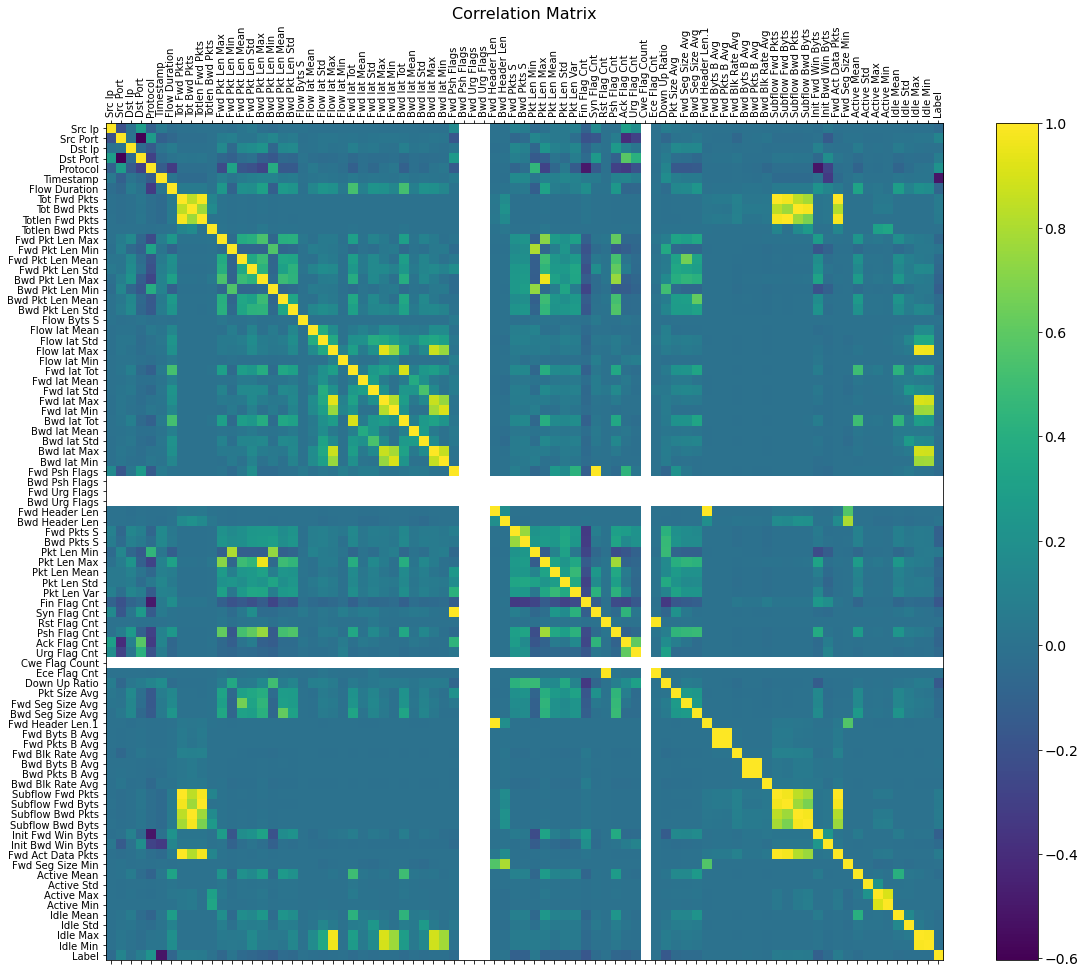

In [15]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

La heatmap descrive la matrice di correlazione e guardandola si nota che ci sono alcune coppie di features che correlano tra di loro anche con valori molto alti (zone in giallo, esclusa la diagonale, e verde), perciò ha senso calcolare la PCA.

Prima di effettuare la PCA necessito di andare a standardizzare i dati

In [87]:
def feature_extraction(data, n_components, norm=False):
    if norm:
        scalar = StandardScaler()
        scalar.fit(data)
        data = scalar.transform(data)

    pca = PCA(n_components)

    pca.fit(data)

    #X_train = pca.transform(X_train)
    #X_test = pca.transform(X_test)

    return pca

In [ ]:
X, y = dataset.loc[:, 'Src Ip' : 'Idle Min'], dataset.loc[:, 'Label']

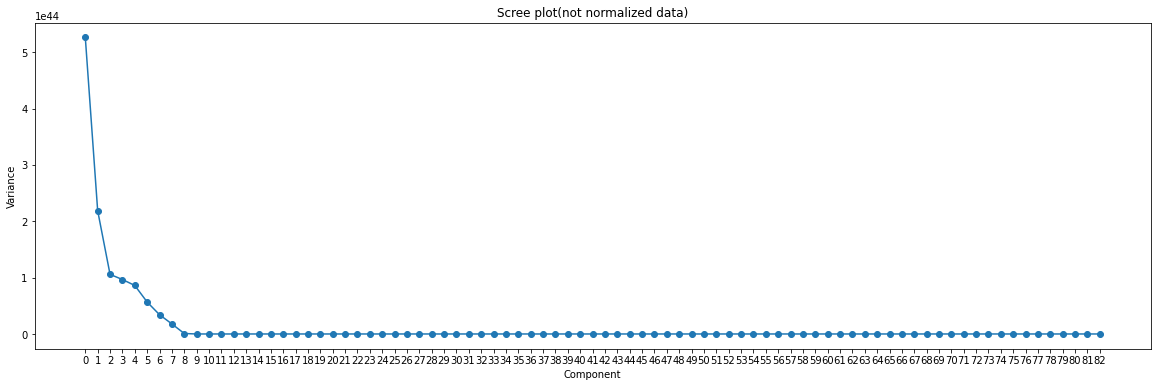

In [94]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, train_size=.8)

#X_train = scalar.transform(X_train)
#X_test = scalar.transform(X_test)
pca = feature_extraction(X, X.shape[1], False)

plt.figure(figsize=(20, 6))
plt.plot(range(pca.n_components_), pca.explained_variance_)
plt.scatter(range(pca.n_components_), pca.explained_variance_)
plt.title("Scree plot(not normalized data)")
plt.xlabel("Component")
plt.xticks(range(pca.n_components_), range(pca.n_components_))
plt.ylabel("Variance")
plt.show()

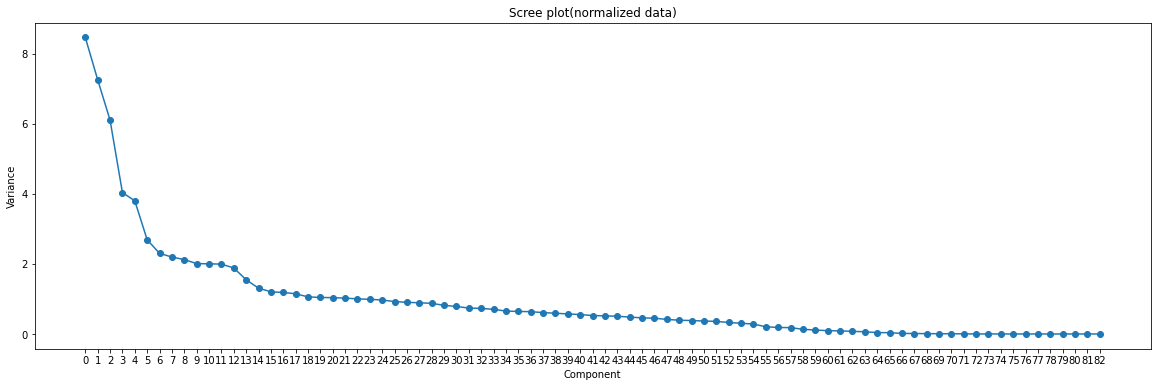

In [96]:
pca_norm = feature_extraction(X, X.shape[1], True)

plt.figure(figsize=(20, 6))
plt.plot(range(pca_norm.n_components_), pca_norm.explained_variance_)
plt.scatter(range(pca_norm.n_components_), pca_norm.explained_variance_)
plt.title("Scree plot(normalized data)")
plt.xlabel("Component")
plt.xticks(range(pca_norm.n_components_), range(pca_norm.n_components_))
plt.ylabel("Variance")
plt.show()

Dai grafici presentati del caso di dati non normalizzati si andrebbero a estrarre **6/7 features**, oppure nel caso di dati normalizzati ado a estrarre **dalle 13 alle 57 features**.

Per trovare con maggior precisione il numero di features attraverso la **regola di Kaiser** in cui si tengono solo le componenti che hanno un valore della varianza(autovalori) non sia **inferiore a 1 oppure a 0.7**. In letteratura la primo valore risulta troppo alto.

In [109]:
print("Threshold 1")
print(f"Regola di Kaiser su dati non normalizzati: {len(pca.explained_variance_[pca.explained_variance_ > 1])} features")
print(f"Regola di Kaiser su dati normalizzati: {len(pca_norm.explained_variance_[pca_norm.explained_variance_ > 1])} features")

Threshold 1
Regola di Kaiser su dati non normalizzati: 83 features
Regola di Kaiser su dati normalizzati: 23 features


In [110]:
print("Threshold 0.7")
print(f"Regola di Kaiser su dati non normalizzati: {len(pca.explained_variance_[pca.explained_variance_ > .7])} features")
print(f"Regola di Kaiser su dati normalizzati: {len(pca_norm.explained_variance_[pca_norm.explained_variance_ > .7])} features")

Threshold 0.7
Regola di Kaiser su dati non normalizzati: 83 features
Regola di Kaiser su dati normalizzati: 34 features


In linea di massima da come si è visto dai risultati sopra la regola di Kaiser funziona solo su **dati normalizzati**, ottenedo un totale di 23 o 34 featiures rispettivamete nel caso in cui il threshold sia 1 o 0.7. Così facendo si riduce del **72%**(23 features) o del **59%**(34 features).

I risultati descritti sopra soddisfano la condizione descritta dai grafici ottenuta analizzando l'andamento dei grafici vedendo dove avviene la suddivisone tra autovalori "grandi" e "piccoli" che viene contrassegnato da un "gomito".

# BILANCIAMENTO DATASET

Prima di tutto voglio andare a vedere come le due classi sono distribuite all'interno del dataset

In [13]:
labels, counts = np.unique(dataset['Label'], return_counts=True)

print(labels)
print(counts)

[0. 1.]
[1592331   94601]


Si vede che la classe *BENIGN*, contrassegnato con lo 0, è quella maggiormente presente con un totale di 1592331 records contro i 94601 dei recods malevoli

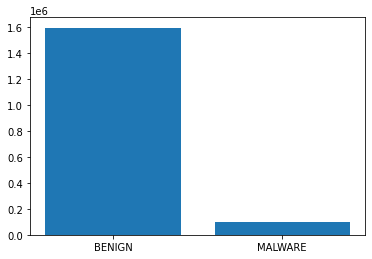

In [15]:
labels = np.where(labels == 0., "BENIGN", "MALWARE")

plt.bar(labels, counts)
plt.show()

Le tecniche che vorrei utilizzare per bilanciare il dataset sono principalmente 2: sfruttare la **focal loss** o la **SMOTE** (Synthetic Minority Oversampling Technique).

In [32]:
del dataset

# ADDESTRAMENTO DEL MODELLO

Prima di addestrare i modelli andiamo a dividere il dataset in training e test set e li memorizzo su file

In [4]:
data = pd.read_csv(f"{DATASET_PATH}/dataset.csv", low_memory=False)
X, y = data.loc[:, 'Src Ip' : 'Idle Min'], data.loc[:, 'Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, train_size=.7)

print("Lettura completata")

Lettura completata


In [ ]:
training_set, test_set =  X_train, X_test

training_set['Label'] = y_train
test_set['Label'] = y_test

#print(test_set)
training_set.to_csv(f"{DATASET_PATH}/train.csv")
test_set.to_csv(f"{DATASET_PATH}/test.csv")

I modelli che andremo a sfruttare sono i seguenti: **Decision Tree**, **Random Forest**, **Neural Tree**, ...(da ampliare la lista).

I modelli saranno addestati con le seguenti modallità, per poi andarli a confrontare provando a determinare quali siano le migliori features atte a rilevare un attacco ransomware analizzando il traffico.

Le modalità di addestramento saranno le seguenti:
* con dataset sbilanciato
* dataset bilanciato

Queste due modalità verranno ripetute sia su dataset con tutte le features e sia dopo una fase di features reduction.

In [4]:
training_set = pd.read_csv(f"{DATASET_PATH}/train.csv", low_memory=False)
test_set = pd.read_csv(f"{DATASET_PATH}/test.csv", low_memory=False)

X_train, y_train = training_set.loc[:, 'Src Ip' : 'Idle Min'], training_set.loc[:, 'Label']
X_test, y_test = test_set.loc[:, 'Src Ip' : 'Idle Min'], test_set.loc[:, 'Label']

print("DATASET ACQUISITI")

del training_set, test_set

DATASET ACQUISITI


In [5]:
oversample = SMOTE()

X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)
X_test_balanced, y_test_balanced = oversample.fit_resample(X_test, y_test)

print("Bilanciamento completato")

Bilanciamento completato


In [50]:
train_balanced = X_train_balanced
train_balanced['Label'] = y_train_balanced

test_balanced = X_test_balanced
test_balanced['Label'] = y_test_balanced

train_balanced.to_csv(f"{DATASET_PATH}/balanced_train.csv")
test_balanced.to_csv(f"{DATASET_PATH}/balanced_test.csv")

In [5]:
training_set_balanced = pd.read_csv(f"{DATASET_PATH}/balanced_train.csv", low_memory=False)
test_set_balanced = pd.read_csv(f"{DATASET_PATH}/balanced_test.csv", low_memory=False)

X_train_balanced, y_train_balanced = training_set_balanced.loc[:, 'Src Ip' : 'Idle Min'], training_set_balanced.loc[:, 'Label']
X_test_balanced, y_test_balanced = test_set_balanced.loc[:, 'Src Ip' : 'Idle Min'], test_set_balanced.loc[:, 'Label']

print("DATASET BILANCIATI ACQUISITI")

del training_set_balanced, test_set_balanced

DATASET BILANCIATI ACQUISITI


## DECISION TREE

### DATASET SBILANCIATO

In [5]:
try:
    with open(f"{EXPORTED_MODEL}/dt_unbalance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/dt_unbalance.pkl")

        dt_model = pkl.load(file)
except IOError:
    dt = DecisionTreeClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    dt_model = dt.fit(X_train, y_train)

    print(f"L'addestramento del decision tree ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/dt_unbalance.pkl")
    with open(f"{EXPORTED_MODEL}/dt_unbalance.pkl", 'wb') as file:
        pkl.dump(dt_model, file)

CARICAMENTO MODELLO DA ../exported_model/dt_unbalance.pkl


Visualizziamo il decision tree

[Text(0.27871429050429186, 0.9761904761904762, 'X[41] <= 0.018\ngini = 0.106\nsamples = 1180852\nvalue = [1114497, 66355]'),
 Text(0.17972103004291845, 0.9285714285714286, 'X[0] <= 101281648.0\ngini = 0.176\nsamples = 62195\nvalue = [6048, 56147]'),
 Text(0.11051502145922747, 0.8809523809523809, 'X[5] <= 1.488899616303743e+18\ngini = 0.04\nsamples = 57197\nvalue = [1159, 56038]'),
 Text(0.07939914163090128, 0.8333333333333334, 'X[3] <= 60.0\ngini = 0.012\nsamples = 56355\nvalue = [328, 56027]'),
 Text(0.04291845493562232, 0.7857142857142857, 'X[5] <= 3640499896320.0\ngini = 0.055\nsamples = 71\nvalue = [69, 2]'),
 Text(0.034334763948497854, 0.7380952380952381, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.05150214592274678, 0.7380952380952381, 'gini = 0.0\nsamples = 69\nvalue = [69, 0]'),
 Text(0.11587982832618025, 0.7857142857142857, 'X[48] <= 0.5\ngini = 0.009\nsamples = 56284\nvalue = [259, 56025]'),
 Text(0.06866952789699571, 0.7380952380952381, 'X[1] <= 108.5\ngini = 0.002\n

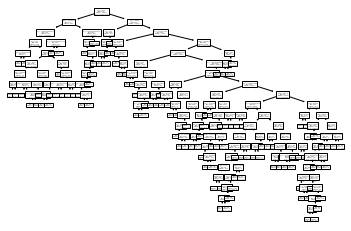

In [6]:
plot_tree(dt_model)

### VALUTAZIONE MODELLO

In [7]:
print(f"Precision in training phase: {dt_model.score(X_train, y_train)}")
print(f"Precision in testing phase: {dt_model.score(X_test, y_test)}")

Precision in training phase: 1.0
Precision in testing phase: 0.9999664084729687


### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

Per fare ciò sfrutto la proprietà *feature_importances\_* messa a disposizione dal modello

Feature: 0, Score: 0.17057
Feature: 1, Score: 0.00120
Feature: 2, Score: 0.00053
Feature: 3, Score: 0.00122
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.03044
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00032
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00015
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00169
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.01864
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00002
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00002
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00002
Feature: 25, Score: 0.00005
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00001
Feature: 32, Score: 0.00025
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

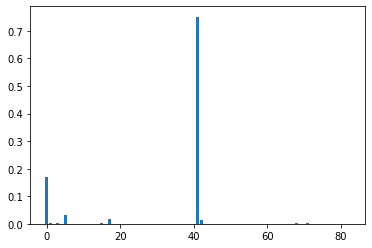

In [8]:
importance = dt_model.feature_importances_

for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i, v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

### DATASET BILANCIATO

In [9]:
try:
    with open(f"{EXPORTED_MODEL}/dt_balance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/dt_balance.pkl")

        dt_balance_model = pkl.load(file)
except IOError:
    dt = DecisionTreeClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    dt_balance_model = dt.fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento del decision tree ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/dt_balance.pkl")
    with open(f"{EXPORTED_MODEL}/dt_balance.pkl", 'wb') as file:
        pkl.dump(dt_balance_model, file)

CARICAMENTO MODELLO DA ../exported_model/dt_balance.pkl


Visualizzo il decision tree

[Text(0.6195534773154053, 0.98, 'X[69] <= 0.5\ngini = 0.5\nsamples = 2228994\nvalue = [1114497, 1114497]'),
 Text(0.5240007949794501, 0.94, 'X[0] <= 101281648.0\ngini = 0.133\nsamples = 1136572\nvalue = [81257, 1055315]'),
 Text(0.4856433133149093, 0.9, 'X[5] <= 1.4877429300713226e+18\ngini = 0.013\nsamples = 1058535\nvalue = [6918, 1051617]'),
 Text(0.4588149713010204, 0.86, 'X[24] <= 2995262.5\ngini = 0.006\nsamples = 1054435\nvalue = [3001, 1051434]'),
 Text(0.41876372945011336, 0.82, 'X[81] <= 30047527.0\ngini = 0.003\nsamples = 1052730\nvalue = [1814, 1050916]'),
 Text(0.37947757227891155, 0.78, 'X[48] <= 0.5\ngini = 0.003\nsamples = 1052308\nvalue = [1537, 1050771]'),
 Text(0.33945401077097503, 0.74, 'X[25] <= 90048756.0\ngini = 0.002\nsamples = 1045170\nvalue = [993, 1044177]'),
 Text(0.29795564058956914, 0.7, 'X[19] <= 1412933.75\ngini = 0.002\nsamples = 1044622\nvalue = [887, 1043735]'),
 Text(0.25124007936507936, 0.66, 'X[81] <= 2995120.625\ngini = 0.002\nsamples = 1044484\nv

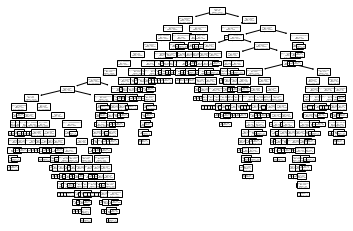

In [10]:
plot_tree(dt_balance_model)

### VALUTAZIONE MODELLO

In [11]:
print(f"Precision in training phase: {dt_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalanced): {dt_balance_model.score(X_test, y_test)}")
print(f"Precision in testing phase(balanced): {dt_balance_model.score(X_test_balanced, y_test_balanced)}")

Precision in training phase: 0.9999780169888299
Precision in testing phase(unbalanced): 0.9999308409737591
Precision in testing phase(balanced): 0.9997886295240607


### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

Per fare ciò sfrutto la proprietà *feature_importance\_* messa a disposizione dal modello

Feature: 0, Score: 0.17659
Feature: 1, Score: 0.00023
Feature: 2, Score: 0.00013
Feature: 3, Score: 0.00001
Feature: 4, Score: 0.00002
Feature: 5, Score: 0.03002
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00001
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00001
Feature: 12, Score: 0.00005
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00003
Feature: 16, Score: 0.00070
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00020
Feature: 19, Score: 0.00016
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00002
Feature: 22, Score: 0.00001
Feature: 23, Score: 0.00001
Feature: 24, Score: 0.00148
Feature: 25, Score: 0.00004
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

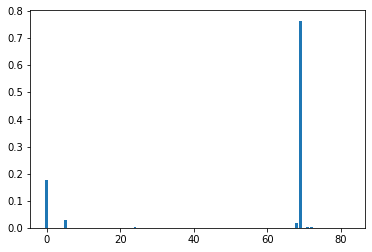

In [12]:
importance = dt_balance_model.feature_importances_

for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i, v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

## RANDOM FOREST

### DATASET SBILANCIATO

In [13]:
try:
    with open(f"{EXPORTED_MODEL}/rf_unbalance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/rf_unbalance.pkl")

        rf_model = pkl.load(file)
except IOError:
    rf = RandomForestClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    rf_model = rf.fit(X_train, y_train)

    print(f"L'addestramento della random forest ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/rf_unbalance.pkl")
    with open(f"{EXPORTED_MODEL}/rf_unbalance.pkl", 'wb') as file:
        pkl.dump(rf_model, file)

CARICAMENTO MODELLO DA ../exported_model/rf_unbalance.pkl


Visualizza la random forest

In [14]:
index = 0
fig, axes = plt.subplots(nrows = 10,ncols = 5,figsize = (10, 10), dpi=900)

for tree in rf_model.estimators_:
    tree.plot_tree(tree)

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
    index += 1

Precision in training phase: 1.0
Precision in testing phase: 0.9999347929181157


### VALUTAZIONE MODELLO

Feature: 0, Score: 0.13031
Feature: 1, Score: 0.00884
Feature: 2, Score: 0.01159
Feature: 3, Score: 0.01292
Feature: 4, Score: 0.02435
Feature: 5, Score: 0.06178
Feature: 6, Score: 0.05730
Feature: 7, Score: 0.00347
Feature: 8, Score: 0.01702
Feature: 9, Score: 0.00932
Feature: 10, Score: 0.00978
Feature: 11, Score: 0.00199
Feature: 12, Score: 0.00401
Feature: 13, Score: 0.00788
Feature: 14, Score: 0.00049
Feature: 15, Score: 0.01485
Feature: 16, Score: 0.00302
Feature: 17, Score: 0.01540
Feature: 18, Score: 0.00040
Feature: 19, Score: 0.04300
Feature: 20, Score: 0.11117
Feature: 21, Score: 0.00872
Feature: 22, Score: 0.00196
Feature: 23, Score: 0.02026
Feature: 24, Score: 0.01307
Feature: 25, Score: 0.00946
Feature: 26, Score: 0.02163
Feature: 27, Score: 0.00046
Feature: 28, Score: 0.00663
Feature: 29, Score: 0.00417
Feature: 30, Score: 0.00017
Feature: 31, Score: 0.00013
Feature: 32, Score: 0.00012
Feature: 33, Score: 0.00014
Feature: 34, Score: 0.00016
Feature: 35, Score: 0.00000
Fe

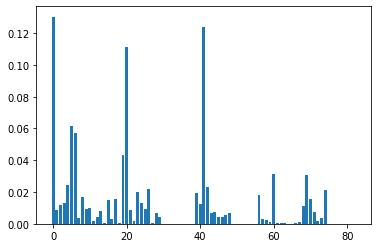

In [15]:
print(f"Precision in training phase: {rf_model.score(X_train, y_train)}")
print(f"Precision in testing phase: {rf_model.score(X_test, y_test)}")

### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

Per fare ciò sfrutto la proprietà *feature_importances\_* messa a disposizione dal modello

In [16]:
importance = rf_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

CARICAMENTO MODELLO DA ../exported_model/rf_balance.pkl


### DATASET BILANCIATO

In [17]:
try:
    with open(f"{EXPORTED_MODEL}/rf_balance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/rf_balance.pkl")

        rf_balance_model = pkl.load(file)
except IOError:
    rf = RandomForestClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    rf_balance_model = rf.fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento della random forest ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/rf_balance.pkl")
    with open(f"{EXPORTED_MODEL}/rf_balance.pkl", 'wb') as file:
        pkl.dump(rf_balance_model, file)

Precision in training phase: 0.9999986541013569
Precision in testing phase(unbalance): 0.9999249130572242
Precision in testing phase(balance): 0.9999393094673046


Visualizza la random forest

Feature: 0, Score: 0.11410
Feature: 1, Score: 0.00121
Feature: 2, Score: 0.00541
Feature: 3, Score: 0.00800
Feature: 4, Score: 0.01309
Feature: 5, Score: 0.08981
Feature: 6, Score: 0.03078
Feature: 7, Score: 0.00294
Feature: 8, Score: 0.09366
Feature: 9, Score: 0.00192
Feature: 10, Score: 0.02744
Feature: 11, Score: 0.00170
Feature: 12, Score: 0.00502
Feature: 13, Score: 0.00206
Feature: 14, Score: 0.00139
Feature: 15, Score: 0.02254
Feature: 16, Score: 0.01402
Feature: 17, Score: 0.04452
Feature: 18, Score: 0.00062
Feature: 19, Score: 0.01438
Feature: 20, Score: 0.03725
Feature: 21, Score: 0.01276
Feature: 22, Score: 0.00535
Feature: 23, Score: 0.00066
Feature: 24, Score: 0.00074
Feature: 25, Score: 0.00252
Feature: 26, Score: 0.00164
Feature: 27, Score: 0.00069
Feature: 28, Score: 0.00149
Feature: 29, Score: 0.00089
Feature: 30, Score: 0.00059
Feature: 31, Score: 0.00318
Feature: 32, Score: 0.00054
Feature: 33, Score: 0.00013
Feature: 34, Score: 0.00010
Feature: 35, Score: 0.00000
Fe

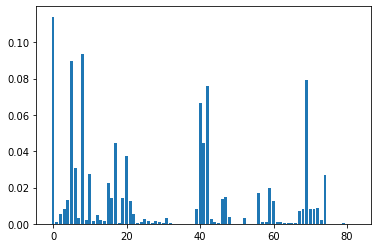

In [18]:
for tree in rf_balance_model.estimators:
    tree.plot_tree(tree)

### VALUTAZIONE MODELLO

In [40]:
print(f"Precision in training phase: {rf_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalance): {rf_balance_model.score(X_test, y_test)}")
print(f"Precision in testing phase(balance): {rf_balance_model.score(X_test_balanced, y_test_balanced)}")

Precision in training phase: 1.0
Precision in testing phase(unbalance): 0.9999249130572242
Precision in testing phase(balance): 0.9999309383593465


### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

Per fare ciò sfrutto la proprietà *feature_importances\_* messa a disposizione dal modello

Feature: 0, Score: 0.11410
Feature: 1, Score: 0.00121
Feature: 2, Score: 0.00541
Feature: 3, Score: 0.00800
Feature: 4, Score: 0.01309
Feature: 5, Score: 0.08981
Feature: 6, Score: 0.03078
Feature: 7, Score: 0.00294
Feature: 8, Score: 0.09366
Feature: 9, Score: 0.00192
Feature: 10, Score: 0.02744
Feature: 11, Score: 0.00170
Feature: 12, Score: 0.00502
Feature: 13, Score: 0.00206
Feature: 14, Score: 0.00139
Feature: 15, Score: 0.02254
Feature: 16, Score: 0.01402
Feature: 17, Score: 0.04452
Feature: 18, Score: 0.00062
Feature: 19, Score: 0.01438
Feature: 20, Score: 0.03725
Feature: 21, Score: 0.01276
Feature: 22, Score: 0.00535
Feature: 23, Score: 0.00066
Feature: 24, Score: 0.00074
Feature: 25, Score: 0.00252
Feature: 26, Score: 0.00164
Feature: 27, Score: 0.00069
Feature: 28, Score: 0.00149
Feature: 29, Score: 0.00089
Feature: 30, Score: 0.00059
Feature: 31, Score: 0.00318
Feature: 32, Score: 0.00054
Feature: 33, Score: 0.00013
Feature: 34, Score: 0.00010
Feature: 35, Score: 0.00000
Fe

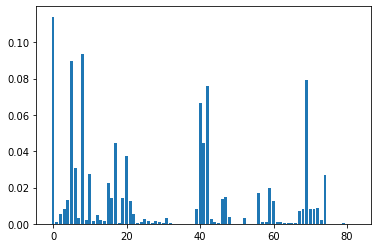

In [41]:
importance = rf_balance_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## BAYESIAN NETWORK

### DATASET SBILANCIATO

#### GAUSSIAN NAIVE BAYES

In [15]:
try:
    with open(f"{EXPORTED_MODEL}/gnb_unbalance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/gnb_unbalance.pkl")

        gnb_model = pkl.load(file)
except IOError:
    gnb = GaussianNB()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO BAYESIAN NETWORK")
    gnb_model = gnb.fit(X_train, y_train)

    print(f"L'addestramento della bayesian network ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/gnd_unbalance.pkl")
    with open(f"{EXPORTED_MODEL}/gnb_unbalance.pkl", 'wb') as file:
        pkl.dump(gnb_model, file)

INIZIO ADDESTRAMENTO BAYESIAN NETWORK
L'addestramento della bayesian network ha impiegato 2.6586413383483887 secondi
SALVATAGGIO MODELLO IN ../exported_model/gnd_unbalance.pkl


##### VALUTAZIONE MODELLO

In [16]:
print(f"Precision in training phase: {gnb_model.score(X_train, y_train)}")
print(f"Precision in testing phase: {gnb_model.score(X_test, y_test)}")

Precision in training phase: 0.07745593859349012
Precision in testing phase: 0.07740278216882707


##### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [ ]:
importance = permutation_importance(gnb_model, X_train, y_train)

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: -0.00286
Feature: 22, Score: -0.00788
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: -0.00108
Feature: 27, Score: -0.00636
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: -0.00090
Feature: 32, Score: -0.00523
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00

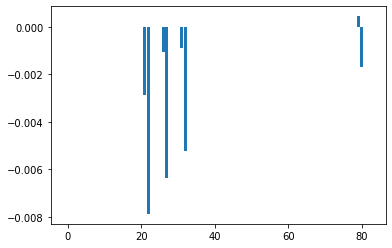

In [22]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### BERNOULLI NAIVE BAYES

In [24]:
try:
    with open(f"{EXPORTED_MODEL}/bnb_unbalance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/bnb_unbalance.pkl")

        bnb_model = pkl.load(file)
except IOError:
    bnb = BernoulliNB()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO BAYESIAN NETWORK")
    bnb_model = bnb.fit(X_train, y_train)

    print(f"L'addestramento della bayesian network ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/bnd_unbalance.pkl")
    with open(f"{EXPORTED_MODEL}/bnb_unbalance.pkl", 'wb') as file:
        pkl.dump(bnb_model, file)

INIZIO ADDESTRAMENTO BAYESIAN NETWORK
L'addestramento della bayesian network ha impiegato 1.9755268096923828 secondi
SALVATAGGIO MODELLO IN ../exported_model/bnd_unbalance.pkl


##### VALUTAZIONE MODELLO

In [25]:
print(f"Precision in training phase: {bnb_model.score(X_train, y_train)}")
print(f"Precision in testing phase: {bnb_model.score(X_test, y_test)}")

Precision in training phase: 0.9655088021191479
Precision in testing phase: 0.965973759089472


##### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [27]:
importance = permutation_importance(bnb_model, X_train, y_train)

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00023
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.01490
Feature: 9, Score: -0.00065
Feature: 10, Score: -0.01435
Feature: 11, Score: -0.00065
Feature: 12, Score: -0.00227
Feature: 13, Score: -0.00065
Feature: 14, Score: -0.00629
Feature: 15, Score: -0.01435
Feature: 16, Score: -0.01310
Feature: 17, Score: -0.01435
Feature: 18, Score: -0.00549
Feature: 19, Score: 0.00014
Feature: 20, Score: 0.00023
Feature: 21, Score: 0.00006
Feature: 22, Score: -0.01029
Feature: 23, Score: 0.00006
Feature: 24, Score: 0.00006
Feature: 25, Score: 0.00014
Feature: 26, Score: 0.00014
Feature: 27, Score: -0.00593
Feature: 28, Score: 0.00014
Feature: 29, Score: 0.00014
Feature: 30, Score: -0.00694
Feature: 31, Score: -0.00694
Feature: 32, Score: -0.00541
Feature: 33, Score: -0.00694
Feature: 34, Score: -0.00714
Feature: 

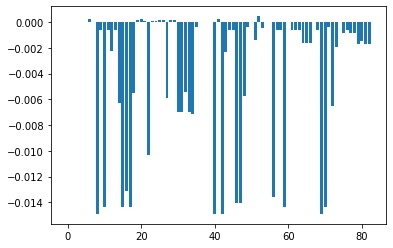

In [28]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### DATASET BILANCIATO

#### GAUSSIAN NAIVE BAYES

In [29]:
try:
    with open(f"{EXPORTED_MODEL}/gnb_balance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/gnb_balance.pkl")

        gnb_balance_model = pkl.load(file)
except IOError:
    gnb = GaussianNB()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO BAYESIAN NETWORK")
    gnb_balance_model = gnb.fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento della bayesian network ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/gnd_balance.pkl")
    with open(f"{EXPORTED_MODEL}/gnb_balance.pkl", 'wb') as file:
        pkl.dump(gnb_balance_model, file)

INIZIO ADDESTRAMENTO BAYESIAN NETWORK
L'addestramento della bayesian network ha impiegato 5.910062789916992 secondi
SALVATAGGIO MODELLO IN ../exported_model/gnd_balance.pkl


##### VALUTAZIONE MODELLO

In [31]:
print(f"Precision in training phase: {gnb_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalance): {gnb_model.score(X_test, y_test)}")
print(f"Precision in testing phase(balance): {gnb_balance_model.score(X_test_balanced, y_test_balanced)}")

Precision in training phase: 0.5112647230095729
Precision in testing phase(unbalance): 0.07740278216882707
Precision in testing phase(balance): 0.51143284069363


##### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [33]:
importance = permutation_importance(gnb_balance_model, X_train_balanced, y_train_balanced)

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00002
Feature: 22, Score: 0.00134
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00001
Feature: 27, Score: 0.00023
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00003
Feature: 32, Score: 0.00006
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

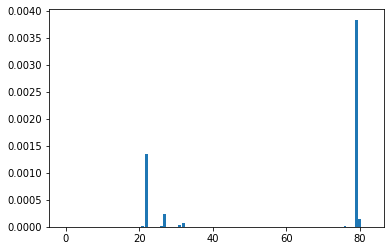

In [34]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### BERNOULLI NAIVE BAYES

In [35]:
try:
    with open(f"{EXPORTED_MODEL}/bnb_balance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/bnb_balance.pkl")

        bnb_balance_model = pkl.load(file)
except IOError:
    bnb = BernoulliNB()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO BAYESIAN NETWORK")
    bnb_balance_model = bnb.fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento della bayesian network ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/bnd_balance.pkl")
    with open(f"{EXPORTED_MODEL}/bnb_balance.pkl", 'wb') as file:
        pkl.dump(bnb_balance_model, file)

INIZIO ADDESTRAMENTO BAYESIAN NETWORK
L'addestramento della bayesian network ha impiegato 3.0971438884735107 secondi
SALVATAGGIO MODELLO IN ../exported_model/bnd_balance.pkl


##### VALUTAZIONE MODELLO

In [36]:
print(f"Precision in training phase: {bnb_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalance): {bnb_model.score(X_test, y_test)}")
print(f"Precision in testing phase(balance): {bnb_balance_model.score(X_test_balanced, y_test_balanced)}")

Precision in training phase: 0.9320837113065356
Precision in testing phase(unbalance): 0.965973759089472
Precision in testing phase(balance): 0.9334109753596437


##### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [37]:
importance = permutation_importance(bnb_balance_model, X_train_balanced, y_train_balanced)

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00005
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00336
Feature: 9, Score: 0.00001
Feature: 10, Score: -0.00340
Feature: 11, Score: 0.00001
Feature: 12, Score: 0.00005
Feature: 13, Score: 0.00001
Feature: 14, Score: -0.00124
Feature: 15, Score: -0.00340
Feature: 16, Score: -0.00319
Feature: 17, Score: -0.00340
Feature: 18, Score: 0.00005
Feature: 19, Score: -0.00136
Feature: 20, Score: 0.00005
Feature: 21, Score: -0.00148
Feature: 22, Score: -0.00059
Feature: 23, Score: -0.00148
Feature: 24, Score: -0.00061
Feature: 25, Score: -0.00072
Feature: 26, Score: -0.00072
Feature: 27, Score: 0.00019
Feature: 28, Score: -0.00072
Feature: 29, Score: -0.00078
Feature: 30, Score: 0.00026
Feature: 31, Score: 0.00026
Feature: 32, Score: 0.00037
Feature: 33, Score: 0.00026
Feature: 34, Score: -0.00160
Feature: 3

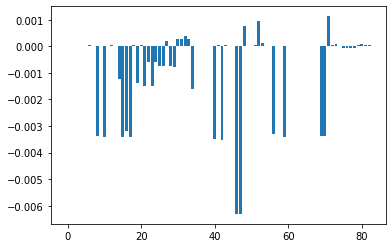

In [38]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## K NEAREST NEIGHBORS

### DATASET SBILANCIATO

In [6]:
try:
    with open(f"{EXPORTED_MODEL}/knn_unbalance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/knn_unbalance.pkl")

        knn_model = pkl.load(file)
except IOError:
    knn = KNeighborsClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    knn_model = knn.fit(X_train, y_train)

    print(f"L'addestramento de k nearest neighbors ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/knn_unbalance.pkl")
    with open(f"{EXPORTED_MODEL}/knn_unbalance.pkl", 'wb') as file:
        pkl.dump(knn_model, file)

CARICAMENTO MODELLO DA ../exported_model/knn_unbalance.pkl


#### VALUTAZIONE MODELLO

In [10]:
print(f"Precision in training phase: {knn_model.score(X_train, y_train)}")
print(f"Precision in testing phase: {knn_model.score(X_test, y_test)}")

Precision in training phase: 0.9960655526687511
Precision in testing phase: 0.9946905627568764


#### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [ ]:
importance = permutation_importance(knn_model, X_train, y_train)

In [ ]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### DATASET BILANCIATO

In [ ]:
try:
    with open(f"{EXPORTED_MODEL}/knn_balance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/knn_balance.pkl")

        knn_balance_model = pkl.load(file)
except IOError:
    knn = KNeighborsClassifier()
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO DECISION TREE")
    knn_balance_model = knn.fit(X_train, y_train)

    print(f"L'addestramento de k nearest neighbors ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/knn_balance.pkl")
    with open(f"{EXPORTED_MODEL}/knn_balance.pkl", 'wb') as file:
        pkl.dump(knn_balance_model, file)

#### VALUTAZIONE MODELLO

In [ ]:
print(f"Precision in training phase: {knn_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalance): {knn_model.score(X_test, y_test)}")
print(f"Precision in testing phase(balance): {knn_balance_model.score(X_test_balanced, y_test_balanced)}")

#### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [ ]:
importance = permutation_importance(knn_balance_model, X_train, y_train)

In [ ]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## NEURAL TREE

### DATASET SBILANCIATO

In [ ]:
try:
    with open(f"{EXPORTED_MODEL}/nt_unbalance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/nt_unbalance.pkl")

        nt = NeuralTree.load_model(f"{EXPORTED_MODEL}/nt_unbalance.pkl")
except IOError:
    nt = NeuralTree(f"{DATASET_PATH}/train.csv", 5)
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO NEURAL TREE")
    nt.train(250, 1)#fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento della bayesian network ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/nt_unbalance.pkl")
    nt.save_model(f"{EXPORTED_MODEL}/nt_unbalance.pkl")

### VALUTAZIONE MODELLO

In [ ]:
print(f"Precision in training phase: {nt.score(X_train, y_train)}")
print(f"Precision in testing phase: {nt.score(X_test, y_test)}")

### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [ ]:
importance = permutation_importance(nt, X_train, y_train)

In [ ]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### DATASET BILANCIATO

In [ ]:
try:
    with open(f"{EXPORTED_MODEL}/nt_balance.pkl", 'rb') as file:
        print("CARICAMENTO MODELLO DA ../exported_model/nt_balance.pkl")

        nt_balance_model = NeuralTree.load_model(f"{EXPORTED_MODEL}/nt_balance.pkl")
except IOError:
    nt = NeuralTree(f"{DATASET_PATH}/balanced_train.csv", 5)
    start_time = time.time()

    print("INIZIO ADDESTRAMENTO NEURAL TREE")
    nt_balance_model = nt.train(500, 0)#fit(X_train_balanced, y_train_balanced)

    print(f"L'addestramento della bayesian network ha impiegato {time.time() - start_time} secondi")

    print("SALVATAGGIO MODELLO IN ../exported_model/nt_unbalance.pkl")
    nt_balance_model.save_model(f"{EXPORTED_MODEL}/nt_balance.pkl")

### VALUTAZIONE MODELLO

In [ ]:
print(f"Precision in training phase: {nt_balance_model.score(X_train_balanced, y_train_balanced)}")
print(f"Precision in testing phase(unbalance): {nt.score(X_test, y_test)}")
print(f"Precision in testing phase(balance): {nt_balance_model.score(X_test_balanced, y_test_balanced)}")

### FEATURES IMPORTANCE/DIMENSIONAL REDUCTION

In [ ]:
importance = permutation_importance(nt_balance_model, X_train, y_train)

In [ ]:
importance = importance['importances_mean']

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# VALUTAZIONE DEL MODELLO
Questa sessione è dedicata all'analisi dei risultati ottenuti dall'analisi dei modelli ottenuti

L'addestramento del decision tree ha impiegato 40.68758296966553 secondi